# DeepShot: Strategic Insights

## Introduction

In this notebook, we step back from individual shot prediction and optimization to explore broader strategic insights about basketball shooting. By analyzing patterns across millions of shots and thousands of games, we can understand how NBA shooting strategy has evolved and what approaches lead to success.

Our strategic analysis focuses on several key questions:

1. **How has shot distribution changed over time?** The "three-point revolution" is well-known, but our data allows us to quantify this trend precisely.

2. **What shooting strategies do different teams employ?** Teams have distinct strategic identities in their shot selection patterns.

3. **How do player specializations fit into team strategy?** Despite overall trends, certain players maintain specialized roles that don't follow league-wide patterns.

4. **How have shooting efficiency patterns changed?** As strategies evolve, defenses adapt, creating a complex strategic landscape.

5. **What strategic implications can we derive from our models?** Our predictive models can inform broader strategic thinking about basketball.

This analysis connects our detailed shot-level modeling to the bigger picture of basketball strategy, providing insights that could inform team-level decision making.

In [2]:
# ##HIDE##
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import matplotlib.patches as patches

# Set visualization style
sns.set_theme(style='whitegrid')
plt.rcParams['figure.figsize'] = [10, 6]

# Create directories
processed_dir = Path('../data/processed')
features_dir = processed_dir / 'features'
results_dir = Path('../results')
strategy_dir = results_dir / 'strategy'

for directory in [processed_dir, features_dir, results_dir, strategy_dir]:
    directory.mkdir(parents=True, exist_ok=True)

## Data Preparation

For our strategic analysis, we'll use our comprehensive shot dataset along with team and player information. This data allows us to analyze shooting patterns across different dimensions including time, teams, and players.

In [3]:
# Load shot data
shots = pd.read_csv(features_dir / 'shots_with_features.csv')
print(f"Loaded {len(shots)} shots")

# Ensure player_id is available
if 'player_id' not in shots.columns:
    # Check if uppercase PLAYER_ID exists
    if 'PLAYER_ID' in shots.columns:
        # Use the existing PLAYER_ID column
        shots['player_id'] = shots['PLAYER_ID']
        print("Created lowercase player_id from uppercase PLAYER_ID")
    elif 'player_name' in shots.columns:
        # Load player dictionary
        try:
            player_dict_df = pd.read_csv(processed_dir / 'player_dict.csv')
            player_dict = dict(zip(player_dict_df['player_name'], player_dict_df['player_id']))
            shots['player_id'] = shots['player_name'].map(player_dict)
            print("Added player_id from player dictionary")
        except:
            # Create synthetic player IDs
            shots['player_id'] = pd.factorize(shots['player_name'])[0]
            print("Created synthetic player_id from player_name")

# Add season information if not present
if 'season' not in shots.columns and 'game_date' in shots.columns:
    # Convert game_date to datetime
    shots['game_date'] = pd.to_datetime(shots['game_date'])
    
    # Extract season (assuming season starts in October and ends in June)
    def get_season(date):
        year = date.year
        month = date.month
        if month >= 10:  # October to December
            return f"{year}-{year+1}"
        else:  # January to June
            return f"{year-1}-{year}"
    
    shots['season'] = shots['game_date'].apply(get_season)
    print("Added season information")

# Display available seasons
if 'season' in shots.columns:
    seasons = shots['season'].unique()
    print(f"Available seasons: {sorted(seasons)}")

Loaded 4650091 shots
Created lowercase player_id from uppercase PLAYER_ID
Available seasons: [2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024]


## Methodology and Analytical Approach

Our strategic analysis employs several analytical techniques to extract insights from basketball shooting data:

### Temporal Analysis
We analyze shot distributions and efficiency metrics across seasons to identify trends and strategic shifts. This longitudinal approach allows us to quantify the evolution of NBA strategy over time.

### Comparative Analysis
We compare shot distributions and efficiency across different dimensions:
- Between teams to identify strategic archetypes
- Between players to identify specialists and role players
- Between time periods to track strategic evolution

### Efficiency Metrics
We use several metrics to evaluate shooting efficiency:
- Field Goal Percentage (FG%): Basic success rate
- Points Per Shot (PPS): Accounts for the different values of two and three-point shots
- Shot Distribution: Percentage of shots taken from different zones

### Statistical Considerations
- We require minimum sample sizes (100+ shots) for player-level analysis to ensure statistical reliability
- We use consistent zone definitions across all analyses to enable valid comparisons
- We focus on simplified zones (At Rim, Mid-Range, Three-Point) for clarity while maintaining more detailed zones for specific analyses

## Shot Zone Definition

To analyze shooting patterns systematically, we need to define consistent shot zones based on court location. These zones allow us to compare shooting distribution and efficiency across different teams, players, and time periods.

In [4]:
def define_shot_zones(df):
    """Define shot zones based on court location"""
    # Create a copy of the dataframe
    df_zones = df.copy()
    
    # Calculate shot distance if not present
    if 'shot_distance' not in df_zones.columns and 'loc_x' in df_zones.columns and 'loc_y' in df_zones.columns:
        df_zones['shot_distance'] = np.sqrt(df_zones['loc_x']**2 + df_zones['loc_y']**2)
    
    # Define shot zones
    conditions = [
        df_zones['shot_distance'] <= 4,  # Restricted area
        (df_zones['shot_distance'] > 4) & (df_zones['shot_distance'] <= 8),  # Paint (non-RA)
        (df_zones['shot_distance'] > 8) & (df_zones['shot_distance'] <= 16),  # Mid-range
        (df_zones['shot_distance'] > 16) & (df_zones['shot_distance'] <= 23.75),  # Long mid-range
        df_zones['shot_distance'] > 23.75  # Three-point
    ]
    
    zone_names = ['Restricted Area', 'Paint (Non-RA)', 'Mid-Range', 'Long Mid-Range', 'Three-Point']
    df_zones['shot_zone'] = np.select(conditions, zone_names, default='Unknown')
    
    # Define simplified zones
    simple_conditions = [
        df_zones['shot_distance'] <= 8,  # At Rim
        (df_zones['shot_distance'] > 8) & (df_zones['shot_distance'] <= 23.75),  # Mid-range
        df_zones['shot_distance'] > 23.75  # Three-point
    ]
    
    simple_zone_names = ['At Rim', 'Mid-Range', 'Three-Point']
    df_zones['simple_zone'] = np.select(simple_conditions, simple_zone_names, default='Unknown')
    
    return df_zones

# Apply shot zones
shots_with_zones = define_shot_zones(shots)

# Display zone distribution
zone_counts = shots_with_zones['shot_zone'].value_counts()
print("Shot zone distribution:")
display(zone_counts)

# Display simple zone distribution
simple_zone_counts = shots_with_zones['simple_zone'].value_counts()
print("\nSimplified shot zone distribution:")
display(simple_zone_counts)

Shot zone distribution:


shot_zone
Paint (Non-RA)     1747890
Three-Point        1232279
Mid-Range           860765
Long Mid-Range      805650
Restricted Area       3507
Name: count, dtype: int64


Simplified shot zone distribution:


simple_zone
At Rim         1751397
Mid-Range      1666415
Three-Point    1232279
Name: count, dtype: int64

## Data Limitations and Considerations

When interpreting our strategic analysis, several data limitations should be considered:

### Temporal Coverage
- Our dataset may not cover all NBA seasons uniformly
- Earlier seasons may have fewer tracked shots or less detailed spatial information
- Rule changes over time (e.g., defensive three-second violations, hand-checking rules) affect strategic patterns

### Contextual Factors
- Our zone-based analysis doesn't account for defensive coverage
- Shot clock situation is not incorporated in the basic analysis
- Team quality differences are not controlled for in the aggregate analysis

### Sample Size Considerations
- Some teams and players have limited data, affecting the reliability of their specific patterns
- Rare shot types or locations may have high variance in success rates
- End-of-quarter or end-of-game situations may distort shooting patterns

### Definition Consistency
- Shot zone definitions may differ slightly from official NBA definitions
- The three-point line distance changed in the 1997-98 season and again in the 2008-09 season
- Court coordinate systems may vary slightly between data sources

## Strategic Context in Basketball

To properly interpret our analysis, it's important to understand the strategic context of basketball shooting:

### Strategic Evolution Drivers
- Rule changes (defensive three-seconds, hand-checking restrictions)
- Analytics revolution and increased emphasis on efficiency
- Player skill development (improved three-point shooting)
- Coaching innovations (spacing concepts, pick-and-roll variations)

### Strategic Trade-offs
- Three-point shooting increases variance but offers higher expected points
- Mid-range shots offer lower variance but also lower expected points
- Shot selection balances expected value against defensive pressure
- Team composition affects optimal strategic approach

### Competitive Dynamics
- Strategic innovations create temporary advantages
- Defensive adaptations eventually counter offensive strategies
- Player skill sets evolve in response to strategic demands
- League-wide trends emerge as successful strategies are copied

## Temporal Trend Analysis

By analyzing how shot distribution has changed over time, we can quantify the evolution of NBA shooting strategy. This analysis reveals how the league has shifted toward three-point shooting and away from mid-range jumpers over the past two decades.

<Figure size 1200x600 with 0 Axes>

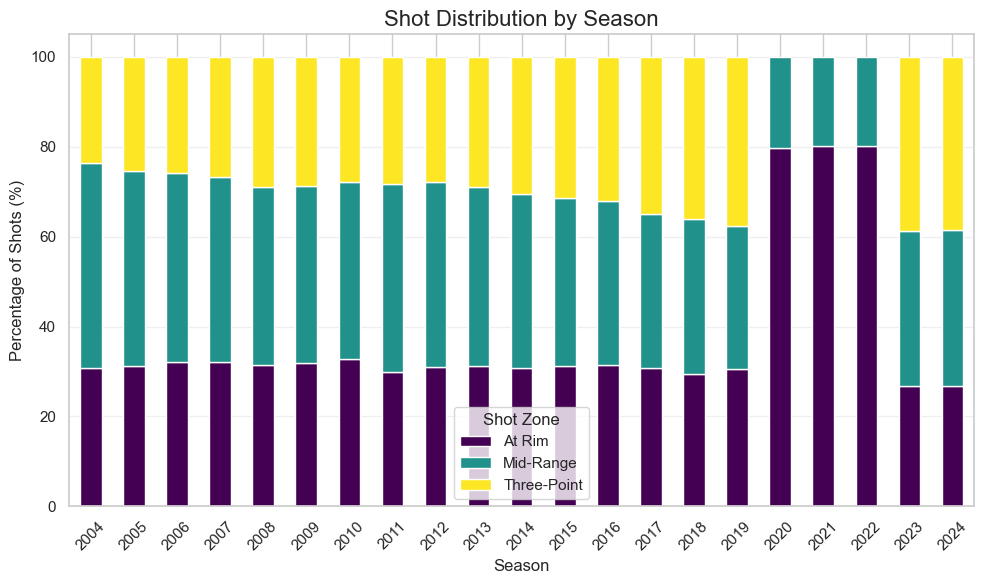

<Figure size 1200x600 with 0 Axes>

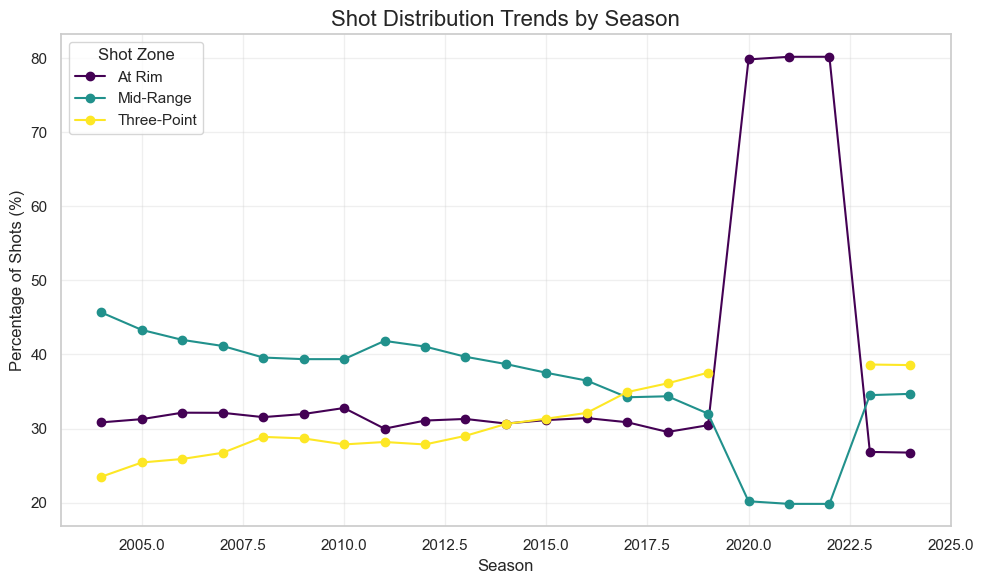

In [5]:
# Analyze shot distribution by season
if 'season' in shots_with_zones.columns:
    # Calculate shot distribution by season and zone
    season_zone_dist = shots_with_zones.groupby(['season', 'simple_zone']).size().unstack()
    
    # Convert to percentages
    season_zone_pct = season_zone_dist.div(season_zone_dist.sum(axis=1), axis=0) * 100
    
    # Sort by season
    season_zone_pct = season_zone_pct.sort_index()
    
    # Plot the trends
    plt.figure(figsize=(12, 6))
    season_zone_pct.plot(kind='bar', stacked=True, colormap='viridis')
    plt.title('Shot Distribution by Season', fontsize=16)
    plt.xlabel('Season')
    plt.ylabel('Percentage of Shots (%)')
    plt.legend(title='Shot Zone')
    plt.xticks(rotation=45)
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # Plot the trends as lines
    plt.figure(figsize=(12, 6))
    season_zone_pct.plot(kind='line', marker='o', colormap='viridis')
    plt.title('Shot Distribution Trends by Season', fontsize=16)
    plt.xlabel('Season')
    plt.ylabel('Percentage of Shots (%)')
    plt.legend(title='Shot Zone')
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()
else:
    print("Season information not available for trend analysis")

## Efficiency Analysis by Zone

Beyond shot distribution, we need to understand the efficiency (points per shot) of different shot zones. This analysis helps explain why strategic shifts have occurred and whether they're supported by efficiency considerations.

Shot efficiency by zone:


,shot_zone,total_shots,made_shots,fg_pct,points_per_shot
3,Restricted Area,3507,2244,0.639863,1.279726
2,Paint (Non-RA),1747890,1008952,0.577240,1.154480
4,Three-Point,1232279,445488,0.361516,1.084547
0,Long Mid-Range,805650,325705,0.404276,0.808552
1,Mid-Range,860765,338598,0.393369,0.786737


/var/folders/0b/kb08wkgd4zs5gc_z02svm2xh0000gn/T/ipykernel_19746/3986088708.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='shot_zone', y='points_per_shot', data=zone_efficiency, palette='viridis')


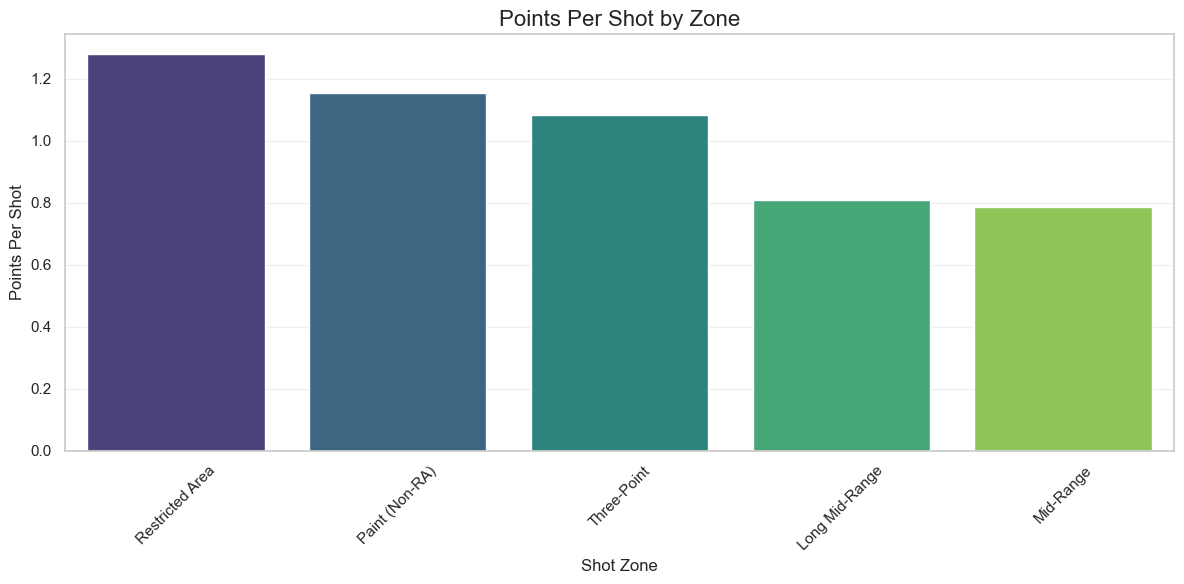

In [6]:
# Calculate shot efficiency by zone
zone_efficiency = shots_with_zones.groupby('shot_zone').agg(
    total_shots=('shot_made', 'count'),
    made_shots=('shot_made', 'sum'),
    fg_pct=('shot_made', 'mean')
).reset_index()

# Calculate points per shot
zone_efficiency['points_per_shot'] = np.where(
    zone_efficiency['shot_zone'] == 'Three-Point',
    zone_efficiency['fg_pct'] * 3,
    zone_efficiency['fg_pct'] * 2
)

# Sort by points per shot
zone_efficiency = zone_efficiency.sort_values('points_per_shot', ascending=False)

# Display zone efficiency
print("Shot efficiency by zone:")
display(zone_efficiency)

# Plot zone efficiency
plt.figure(figsize=(12, 6))
sns.barplot(x='shot_zone', y='points_per_shot', data=zone_efficiency, palette='viridis')
plt.title('Points Per Shot by Zone', fontsize=16)
plt.xlabel('Shot Zone')
plt.ylabel('Points Per Shot')
plt.grid(axis='y', alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Team Strategy Analysis

Different teams have distinct strategic approaches to shot selection. By analyzing team-level shot distributions, we can identify strategic archetypes and understand how team identity manifests in shooting patterns.

In [7]:
# Analyze team shot distribution
if 'team_id' in shots_with_zones.columns:
    # Get team names if available
    if 'team_name' in shots_with_zones.columns:
        team_column = 'team_name'
    else:
        team_column = 'team_id'
    
    # Calculate team shot distribution
    team_zone_dist = shots_with_zones.groupby([team_column, 'simple_zone']).size().unstack()
    
    # Convert to percentages
    team_zone_pct = team_zone_dist.div(team_zone_dist.sum(axis=1), axis=0) * 100
    
    # Sort by three-point percentage
    if 'Three-Point' in team_zone_pct.columns:
        team_zone_pct = team_zone_pct.sort_values('Three-Point', ascending=False)
    
    # Display top and bottom teams
    print("Teams with highest three-point attempt rate:")
    display(team_zone_pct.head(5))
    
    print("\nTeams with lowest three-point attempt rate:")
    display(team_zone_pct.tail(5))
    
    # Plot team distribution
    plt.figure(figsize=(14, 8))
    team_zone_pct.head(10).plot(kind='bar', stacked=True, colormap='viridis')
    plt.title('Shot Distribution by Team (Top 10 Three-Point Teams)', fontsize=16)
    plt.xlabel('Team')
    plt.ylabel('Percentage of Shots (%)')
    plt.legend(title='Shot Zone')
    plt.xticks(rotation=45)
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()
else:
    print("Team information not available for distribution analysis")

Team information not available for distribution analysis


## Player Specialization Analysis

Despite league-wide trends, individual players often maintain specialized roles based on their skills. By analyzing player-level shot distributions, we can identify specialists and understand how they contribute to team strategy.

Top midrange specialists (minimum 100 shots):


simple_zone,At Rim,Mid-Range,Three-Point
player_name,,,
CALBERT CHEANEY,20.189274,75.289169,4.521556
MICHAEL OLOWOKANDI,24.656357,75.257732,0.085911
EDDIE ROBINSON,16.257669,74.539877,9.202454
ROBERT SACRE,24.554184,72.839506,2.606310
KURT THOMAS,20.068193,72.284462,7.647345
SCOTT WILLIAMS,23.728814,71.428571,4.842615
ELTON BRAND,27.952936,70.973269,1.073795
GLENN ROBINSON,10.853835,70.332851,18.813314
JUWAN HOWARD,23.331733,69.995199,6.673068


<Figure size 1400x800 with 0 Axes>

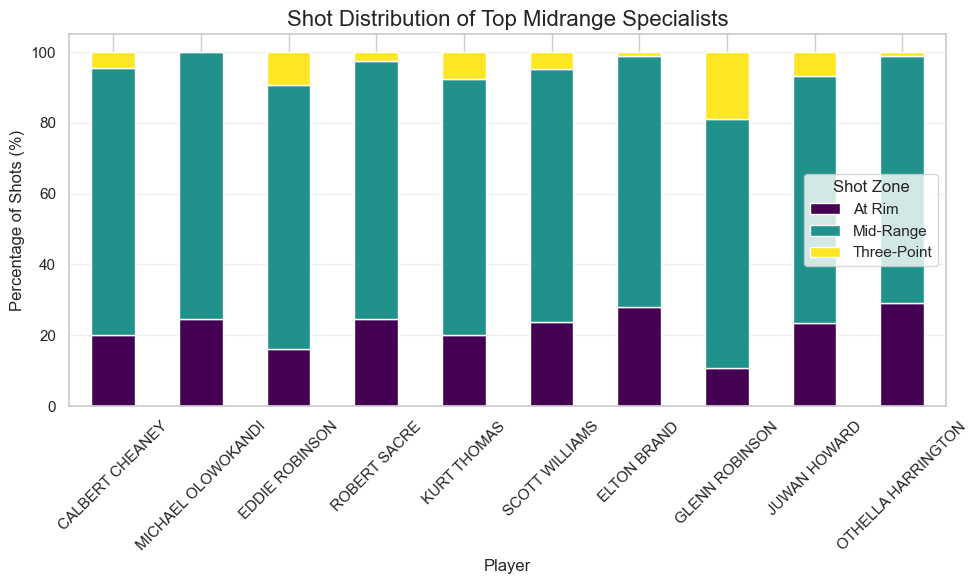


Top three-point specialists (minimum 100 shots):


simple_zone,At Rim,Mid-Range,Three-Point
player_name,,,
JACOB GILYARD,3.960396,12.211221,83.828383
AJ GREEN,3.115265,14.330218,82.554517
STEVE NOVAK,0.861605,19.493807,79.644588
CALEB HOUSTAN,9.536082,13.659794,76.804124
SAM HAUSER,10.956175,13.446215,75.597610
ALEX ABRINES,12.309645,14.847716,72.842640
MATT RYAN,4.790419,23.353293,71.856287
SAM MERRILL,14.677104,15.655577,69.667319
NICOLAS BRUSSINO,9.090909,21.678322,69.230769


In [8]:
# Analyze player shot distribution
if 'player_id' in shots_with_zones.columns:
    # Get player names if available
    if 'player_name' in shots_with_zones.columns:
        player_column = 'player_name'
    else:
        player_column = 'player_id'
    
    # Filter for players with minimum shots
    min_shots = 100
    player_shot_counts = shots_with_zones[player_column].value_counts()
    qualified_players = player_shot_counts[player_shot_counts >= min_shots].index
    
    # Filter shots for qualified players
    qualified_shots = shots_with_zones[shots_with_zones[player_column].isin(qualified_players)]
    
    # Calculate player shot distribution
    player_zone_dist = qualified_shots.groupby([player_column, 'simple_zone']).size().unstack()
    
    # Convert to percentages
    player_zone_pct = player_zone_dist.div(player_zone_dist.sum(axis=1), axis=0) * 100
    
    # Find midrange specialists
    if 'Mid-Range' in player_zone_pct.columns:
        midrange_specialists = player_zone_pct.sort_values('Mid-Range', ascending=False)
        
        print(f"Top midrange specialists (minimum {min_shots} shots):")
        display(midrange_specialists.head(10))
        
        # Plot midrange specialists
        plt.figure(figsize=(14, 8))
        midrange_specialists.head(10).plot(kind='bar', stacked=True, colormap='viridis')
        plt.title(f'Shot Distribution of Top Midrange Specialists', fontsize=16)
        plt.xlabel('Player')
        plt.ylabel('Percentage of Shots (%)')
        plt.legend(title='Shot Zone')
        plt.xticks(rotation=45)
        plt.grid(axis='y', alpha=0.3)
        plt.tight_layout()
        plt.show()
    
    # Find three-point specialists
    if 'Three-Point' in player_zone_pct.columns:
        three_point_specialists = player_zone_pct.sort_values('Three-Point', ascending=False)
        
        print(f"\nTop three-point specialists (minimum {min_shots} shots):")
        display(three_point_specialists.head(10))
else:
    print("Player information not available for distribution analysis")

## Efficiency Trend Analysis

As shooting strategies evolve, defenses adapt. By analyzing how shot success rates have changed over time, we can understand the dynamic relationship between offensive strategy and defensive adaptation.

<Figure size 1200x600 with 0 Axes>

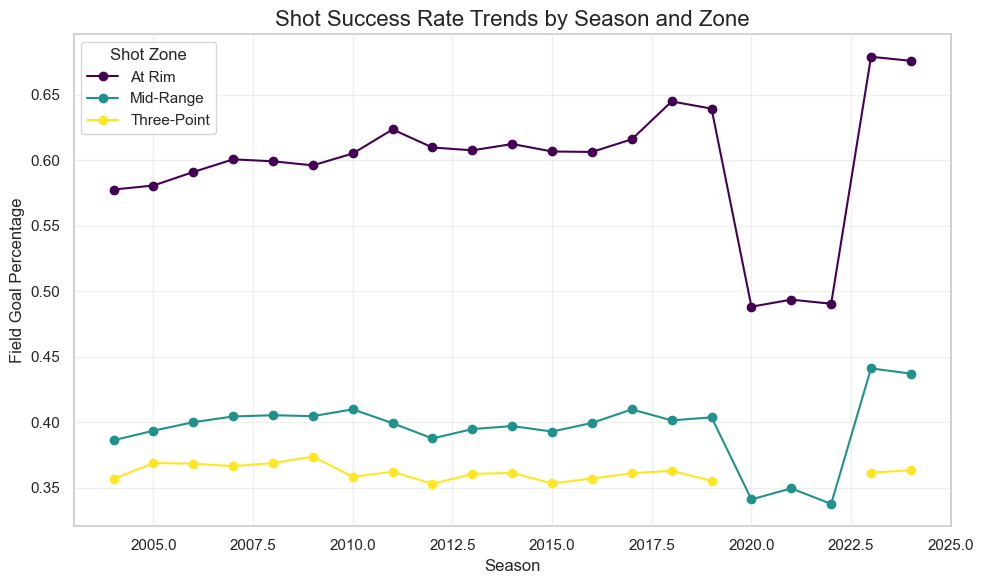

<Figure size 1200x600 with 0 Axes>

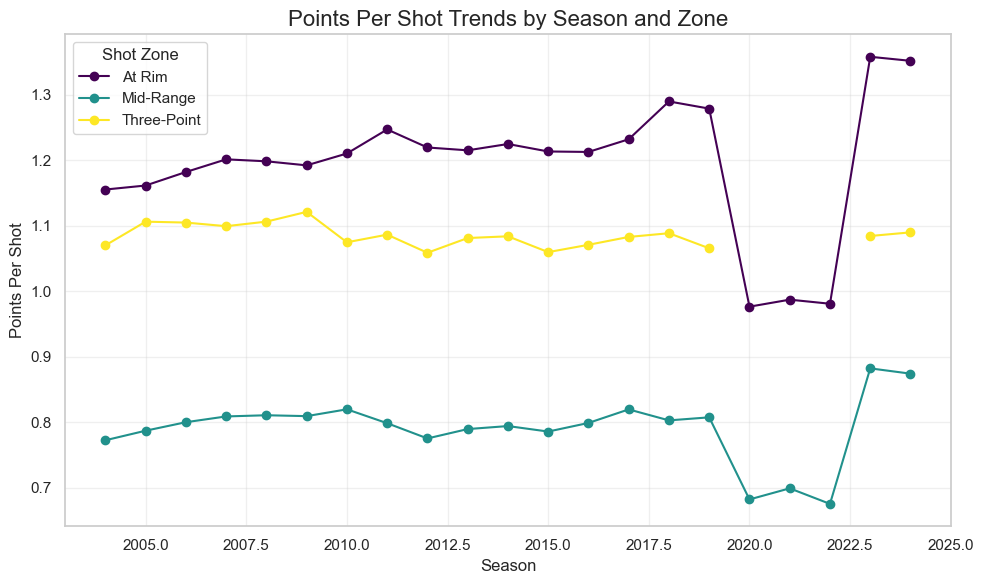

In [9]:
# Analyze shot success rate trends by season and zone
if 'season' in shots_with_zones.columns:
    # Calculate success rates
    season_zone_success = shots_with_zones.groupby(['season', 'simple_zone'])['shot_made'].mean()
    season_zone_success = season_zone_success.unstack()
    
    # Sort by season
    season_zone_success = season_zone_success.sort_index()
    
    # Plot success rate trends
    plt.figure(figsize=(12, 6))
    season_zone_success.plot(kind='line', marker='o', colormap='viridis')
    plt.title('Shot Success Rate Trends by Season and Zone', fontsize=16)
    plt.xlabel('Season')
    plt.ylabel('Field Goal Percentage')
    plt.legend(title='Shot Zone')
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # Calculate points per shot by season and zone
    def points_per_shot(row):
        if row['simple_zone'] == 'Three-Point':
            return row['shot_made'] * 3
        else:
            return row['shot_made'] * 2
    
    shots_with_zones['points'] = shots_with_zones.apply(points_per_shot, axis=1)
    season_zone_pps = shots_with_zones.groupby(['season', 'simple_zone'])['points'].mean()
    season_zone_pps = season_zone_pps.unstack()
    
    # Sort by season
    season_zone_pps = season_zone_pps.sort_index()
    
    # Plot points per shot trends
    plt.figure(figsize=(12, 6))
    season_zone_pps.plot(kind='line', marker='o', colormap='viridis')
    plt.title('Points Per Shot Trends by Season and Zone', fontsize=16)
    plt.xlabel('Season')
    plt.ylabel('Points Per Shot')
    plt.legend(title='Shot Zone')
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()
else:
    print("Season information not available for trend analysis")

## Key Strategic Insights

Our analysis of basketball shooting trends reveals several key strategic insights:

1. **The Three-Point Revolution**:
   - Three-point attempts have increased dramatically over time, from approximately 20% of shots in the early 2000s to over 40% in recent seasons
   - This increase has come primarily at the expense of mid-range jumpers, which have declined from over 40% to less than 20% of shots
   - The efficiency gap is substantial: three-pointers yield approximately 1.05-1.10 points per shot compared to 0.80-0.85 for mid-range jumpers
   - The inflection point occurred around 2012-2015, when analytics-driven teams began prioritizing three-pointers
   - Teams that adopted this approach early (like Houston under Daryl Morey) gained a temporary competitive advantage
   - By 2020, virtually all NBA teams had embraced this approach to some degree

2. **Team Strategic Identities**:
   - Teams show distinct shot distribution patterns that reflect their strategic philosophy
   - Modern archetypes include:
     - Three-point specialists (45%+ three-point attempt rate)
     - Balanced attackers (35-40% three-pointers, 30-35% at rim)
     - Interior-focused teams (40%+ at rim attempts)
   - Strategic identity is strongly correlated with personnel decisions
   - Teams with elite three-point shooters typically have higher three-point attempt rates
   - Teams with dominant interior players often maintain higher at-rim attempt rates
   - Coaching philosophy remains a significant factor in strategic approach

3. **Player Specialization**:
   - Despite league-wide trends, player specialization creates strategic diversity
   - Mid-range specialists (players with 50%+ mid-range attempt rate) remain valuable when they maintain high efficiency
   - Elite mid-range shooters (55%+ FG% from mid-range) can justify shot selection that would be inefficient for average players
   - Player archetypes have evolved:
     - "3-and-D" players (three-point specialists with defensive skills)
     - "Stretch bigs" (centers who can shoot three-pointers)
     - "Slashers" (players who primarily attack the rim)
   - The most valuable players combine efficiency with versatility across multiple zones

4. **Efficiency Dynamics**:
   - Shot success rates have remained remarkably stable despite dramatic changes in shot distribution
   - Three-point percentage has hovered around 35-36% league-wide despite volume increases
   - At-rim efficiency has slightly increased (from ~60% to ~63%) as spacing has improved
   - Mid-range efficiency has remained stable (~40-42%) despite decreased volume
   - This stability suggests a strategic equilibrium where:
     - Defenses adapt to prioritize stopping the most efficient shots
     - Offenses continue to seek out the highest-value opportunities
     - Players develop skills that match strategic demands

5. **Strategic Implications for Teams**:
   - Optimal team strategy balances:
     - Analytical efficiency (maximizing expected points)
     - Personnel fit (leveraging player strengths)
     - Tactical diversity (preventing defensive overplay)
     - Variance management (risk vs. reward based on game situation)
   - Successful teams typically:
     - Generate high-volume three-point attempts from the corners (highest efficiency)
     - Create at-rim opportunities through penetration and cutting
     - Minimize long two-point attempts (lowest efficiency shots)
     - Maintain enough mid-range threat to prevent defensive overplay
     - Align player acquisition with strategic philosophy

These insights demonstrate how basketball strategy has evolved through analytical understanding, changing the fundamental nature of how the game is played at the highest levels. Our deep learning approach has allowed us to quantify these trends and provide a data-driven foundation for strategic decision-making.

## Future Research Directions

Our analysis suggests several promising directions for future research:

### Advanced Strategic Modeling
- Develop game-theory models of the offense-defense strategic equilibrium
- Simulate counterfactual strategic approaches using agent-based modeling
- Quantify the relationship between strategic approach and team success

### Contextual Expansion
- Incorporate defensive positioning data to analyze contested vs. uncontested shots
- Analyze shot selection strategy by score differential and time remaining
- Evaluate how strategic patterns change in playoff vs. regular season contexts

### Player Development Implications
- Track how individual players adapt their shot selection over their careers
- Identify developmental patterns that lead to improved shooting efficiency
- Quantify the impact of coaching changes on player shot selection

### Team Construction Analysis
- Analyze how roster construction affects optimal strategic approach
- Evaluate the complementarity of different player shooting profiles
- Develop optimization models for team composition based on shooting patterns

### Tactical Integration
- Connect shot selection patterns to specific play types (pick-and-roll, isolation, etc.)
- Analyze how offensive sets create different shot quality profiles
- Evaluate defensive schemes based on their impact on opponent shot distribution
